In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
names = open('../names.txt').read().splitlines()
vocab = sorted(list(set(''.join(names))))
vocab.append('.')

In [5]:
stoi = {s: i+1 for i,s in enumerate(vocab)}
stoi['.'] = 0
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [6]:
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
print(names[0:5])

['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [10]:
context_length = 3

def build_dataset(names):
    X, Y = [], []

    for n in names:
        # print(n)
        context = [0]*context_length
        for ch in n + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->',itos[ix])
            context = context[1:] + [ix]      

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [11]:
import random
len(names)
random.seed(42)
n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)
random.shuffle(names)
Xtr, Ytr = build_dataset(names[:n1])
Xval, Yval = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])
print("Training Set Size:", "\n","Xtr:", Xtr.shape,"\n","Ytr:",Ytr.shape)
print("Validation Set Size:", "\n","Xval:", Xval.shape,"\n","Yval:",Yval.shape)
print("Test Set Size:", "\n","Xte:", Xte.shape,"\n","Yte:",Yte.shape)
# print(Xval.shape, Yval.shape)
# print(Xte.shape, Yte.shape)


Training Set Size: 
 Xtr: torch.Size([182580, 3]) 
 Ytr: torch.Size([182580])
Validation Set Size: 
 Xval: torch.Size([22767, 3]) 
 Yval: torch.Size([22767])
Test Set Size: 
 Xte: torch.Size([22799, 3]) 
 Yte: torch.Size([22799])


In [11]:
vocab_size = 27
embedding_dim = 10
hidden_dim = 200

class NamePredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(NamePredictor,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * context_length, hidden_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim) 
        self.nonlin = nn.Tanh()
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

        # Kaiming initialization
        nn.init.kaiming_normal_(self.linear1.weight, mode='fan_out', nonlinearity='tanh')
        nn.init.zeros_(self.linear1.bias)

    def forward(self, x):
        embedded = self.embedding(x)
        flattened = embedded.view(embedded.shape[0], embedding_dim * context_length)
        linear1_output = self.linear1(flattened)
        nonlin_output = self.nonlin(linear1_output)
        output = self.linear2(nonlin_output)
        # return nonlin_output, output
        return output

In [12]:
# Learning rate and batch size experiment
num_epochs = 512
batch_size = 1024

lrexp = torch.linspace(-3,0.5,num_epochs, requires_grad=False)
lrs_val = 10**lrexp

lri = []
lossi = []

In [13]:
# Initialize network, loss and optimizer
loss_function = nn.CrossEntropyLoss()
model = NamePredictor(vocab_size, embedding_dim, hidden_dim)
optimizer = optim.SGD(model.parameters(), lr=lrs_val[0])

In [14]:
## Model initialization checks

# ix = torch.randint(0, Xtr.shape[0], (batch_size,))
# inputs = Xtr[ix]

# with torch.no_grad():
#     tanh_out, output = model(inputs)

# # tanh_out.shape, output.shape
# # (torch.Size([182625, 200]), torch.Size([182625, 27]))

# import matplotlib.pyplot as plt

# # plot histogram of tanh
# # Flatten the tensor for histogram
# # Plot histogram
# plt.hist(tanh_out.view(-1).tolist(), bins=50, density=True, alpha=0.7, color='blue')
# plt.title('Histogram of Tanh Output Values')
# plt.xlabel('Tanh Output Values')
# plt.ylabel('Frequency')
# plt.show()
## This is not bad at all - it shows a distribution bunched up at the center - so most of the tanh gradients will be in active part

In [15]:
# tanh_activations = [abs(t) > 0.99  for t in tanh_values]
# plt.figure(figsize=(20,10))
# plt.imshow(tanh_out.abs() > 0.95, cmap='gray', interpolation='nearest')
## This is not bad either - few columns which have a sprinkling of less active neurons but largely seems ok

In [16]:
# Training loop with mini-batches and lr sweep
for epoch in range(num_epochs):

    ## Set learning rate
    for g in optimizer.param_groups:
        g['lr'] = lrs_val[epoch]

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    inputs = Xtr[ix]
    labels = Ytr[ix]

    # Forward pass
    outputs = model(inputs)
    loss = loss_function(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lri.append(lrs_val[epoch])
    lossi.append(loss.item())

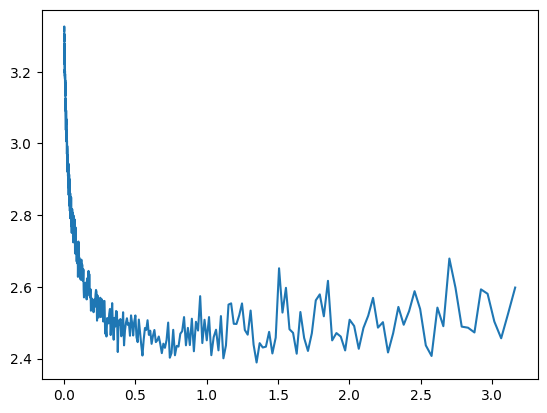

In [17]:
import matplotlib.pyplot as plt

plt.plot(lri, lossi)

In [18]:
# Lists to store training and validation loss for plotting
train_loss_list = []
val_loss_list = []
stepi = []

In [87]:
## Setting the value for optimal lr and batch size. Note that optimal learning rate is batch size dependent since smaller batches are noisier and hence will work better with lower learning rate. So for optimal performance find largest batch size hardware will support and tune lr accordingly.

lr = 0.0001
batch_size = 1024
optimizer = optim.SGD(model.parameters(), lr=lr)

In [98]:
num_epochs = 500000
# Training loop with fixed lr and batch size. Plotting training and validation losses
for epoch in range(num_epochs):

    ix = torch.randint(0, Xtr.shape[0],(batch_size,))

    inputs = Xtr[ix]
    labels = Ytr[ix]

    # Forward pass
    outputs = model(inputs)
    loss = loss_function(outputs, labels)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_list.append(loss.item())

    # with torch.no_grad():
    #     val_outputs = model(Xval)
    #     val_loss_list.append(loss_function(val_outputs, Yval))

    if epoch % 10000 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
        with torch.no_grad():
            val_outputs = model(Xval)
            val_loss_list.append(loss_function(val_outputs, Yval))
            stepi.append(len(train_loss_list))


Epoch: 0, Loss: 1.947586178779602
Epoch: 10000, Loss: 2.032870292663574
Epoch: 20000, Loss: 2.051562786102295
Epoch: 30000, Loss: 1.9872709512710571
Epoch: 40000, Loss: 1.996014952659607
Epoch: 50000, Loss: 2.0135838985443115
Epoch: 60000, Loss: 1.881853461265564
Epoch: 70000, Loss: 2.024040937423706
Epoch: 80000, Loss: 2.0486738681793213
Epoch: 90000, Loss: 2.0101921558380127
Epoch: 100000, Loss: 1.9979530572891235
Epoch: 110000, Loss: 1.9228267669677734
Epoch: 120000, Loss: 1.9644825458526611
Epoch: 130000, Loss: 2.0594887733459473
Epoch: 140000, Loss: 1.9170500040054321
Epoch: 150000, Loss: 1.9313240051269531
Epoch: 160000, Loss: 2.017137289047241
Epoch: 170000, Loss: 2.016552448272705
Epoch: 180000, Loss: 1.9736453294754028
Epoch: 190000, Loss: 1.9734349250793457
Epoch: 200000, Loss: 1.9847911596298218
Epoch: 210000, Loss: 2.0299856662750244
Epoch: 220000, Loss: 1.9973880052566528
Epoch: 230000, Loss: 2.018721580505371
Epoch: 240000, Loss: 2.00846791267395
Epoch: 250000, Loss: 1.96

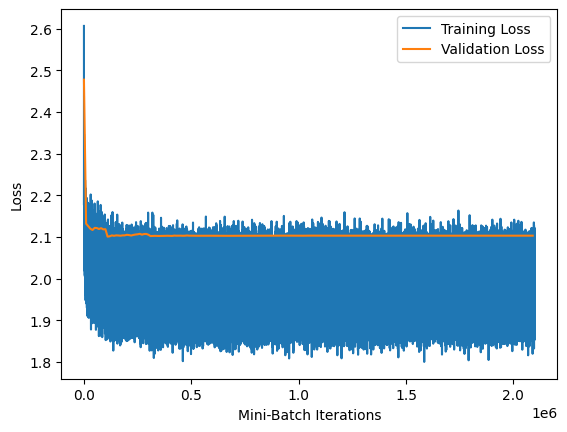

In [110]:
# Plot training and validation loss
# plt.plot((torch.tensor(train_loss_list)).view(-1,1000).mean(1), label='Training Loss')
plt.plot(train_loss_list, label='Training Loss')
plt.plot(stepi, val_loss_list, label='Validation Loss')
plt.xlabel('Mini-Batch Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [90]:
# Check how we are doing in terms of over training

@torch.no_grad()
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 'validation': (Xval, Yval), 'test': (Xte, Yte)}[split]
    output = model(x)
    loss = loss_function(output, y)
    return loss.item()

In [91]:
train, val = split_loss('train'), split_loss('validation')
print(train, val)

1.9768213033676147 2.1029231548309326


In [92]:
# Extract the embedding matrix:
embedding_matrix = model.embedding.weight.data.numpy()
embedding_matrix.shape

(27, 10)

In [93]:
from sklearn.decomposition import PCA

# PCA example:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

In [94]:
n = 1
reduced_embeddings[n], itos[n]

(array([ 0.4631343 , -0.06470521], dtype=float32), 'a')

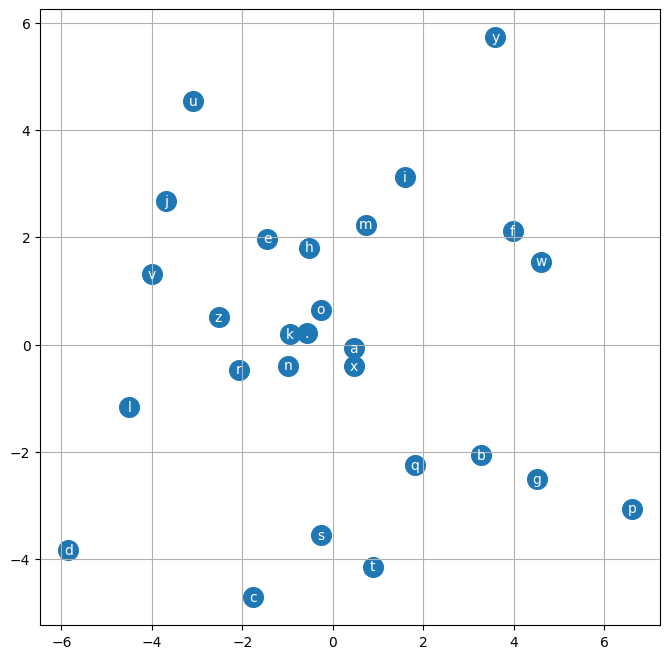

In [95]:
# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embedding_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [96]:
from sklearn.manifold import TSNE

# t-SNE example:
tsne = TSNE(n_components=2, perplexity=5)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

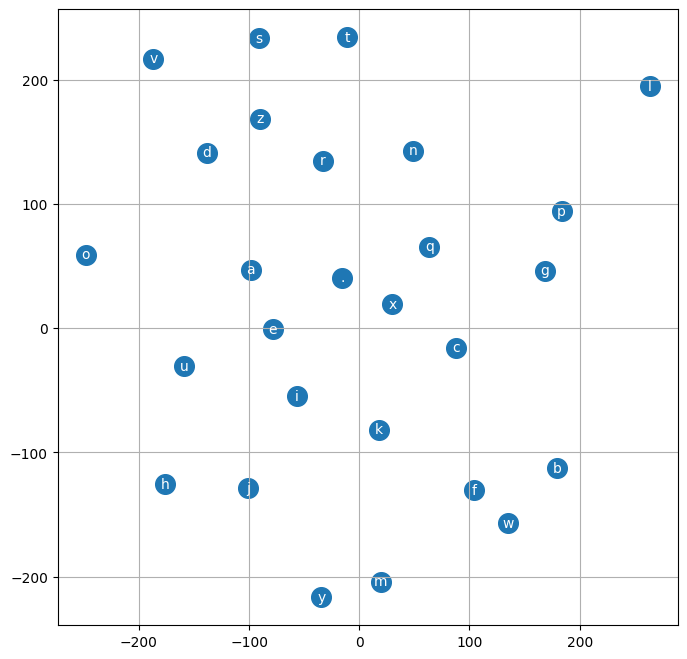

In [97]:
# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embedding_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# # visualize dimensions 0 and 1 of the embedding matrix for all characters
# plt.figure(figsize=(8,8))
# plt.scatter(embedding_matrix[:,0].data, embedding_matrix[:,1].data, s=200)
# for i in range(embedding_matrix.shape[0]):
#     plt.text(embedding_matrix[i,0].item(), embedding_matrix[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

In [ ]:
## Function to generate a set of names
import torch.nn.functional as F

def generate_name(model, num_of_names):
    # Sample from the model for Inference
    new_names = []
    # g = torch.Generator().manual_seed(2147483647 + 10)

    for _ in range(num_of_names):
        
        out = []
        context = [0] * context_length # initialize with all ...
        while True:
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            # ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
    
        nn = ''.join(itos[i] for i in out)
        new_names.append(nn)
    
    return new_names
    

In [ ]:
generate_name(model,5)